# Randomized SVD on large ERA5 slice

This demo notebook shows the application of Randomized SVD to a 17 GiB slice of the [ERA5 dataset](https://weatherbench2.readthedocs.io/en/latest/data-guide.html#era5). It highlights the performance difference of the randomized SVD algorithm when using different rechunking strategies. The algorithm supports chunking across both the rows and columns of the array $\mathbf{X}$. However, the example presented here shows that, for a tall-and-skinny matrix, **it is preferable to have a all columns in a single chunk if they can fit into memory**. This generally leads to more accurate and more efficient randomized SVD.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from svdrom.dask_utils import init_dask
from svdrom.io import open_dataarray
from svdrom.preprocessing import StandardScaler, variable_spatial_stack
from svdrom.svd import TruncatedSVD

Start a local cluster with multi-threading. You can monitor the progress of the computations on the Dask dashboard (http://localhost:8787/status).

In [2]:
client = init_dask(dashboard=True)

2025-08-01 14:01 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
2025-08-01 14:01 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status


2025-08-01 14:02:32,702 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d20094a819ec43d4d73606656e8b2bd initialized by task ('reshape-sub-transpose-rechunk-transfer-f1e4ebfbe9f928ec30cba5ac5d610b8e', 0, 0, 0, 99) executed on worker inproc://192.168.1.116/29008/4
2025-08-01 14:03:05,306 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d20094a819ec43d4d73606656e8b2bd deactivated due to stimulus 'task-finished-1754053385.223114'
2025-08-01 14:10:55,779 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d20094a819ec43d4d73606656e8b2bd initialized by task ('reshape-sub-transpose-rechunk-transfer-f1e4ebfbe9f928ec30cba5ac5d610b8e', 0, 0, 0, 33) executed on worker inproc://192.168.1.116/29008/4
2025-08-01 14:11:28,820 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d20094a819ec43d4d73606656e8b2bd deactivated due to stimulus 'task-finished-1754053888.353236'


Open the ERA5 slice containing temperature data for the year 2018, allowing Dask to auto-chunk the data.

In [3]:
era5_path = "data/era5_slice.zarr"
X = open_dataarray(era5_path)

2025-08-01 14:01 - I/O - INFO - Opening Xarray.DataArray from data/era5_slice.zarr.


As shown below, chunking has only occurred along the `time` dimension, giving a chunk size of approximately 130 MiB. 

In [4]:
X

<xarray.DataArray 'temperature' (time: 4380, latitude: 721, longitude: 1440)> Size: 18GB
dask.array<open_dataset-temperature, shape=(4380, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 35kB 2018-01-01 ... 2018-12-31T22:00:00
    level      int64 8B ...
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

Subtract the time average from the array and perform spatial stacking.

In [5]:
scaler = StandardScaler()
X = scaler(X)
X = variable_spatial_stack(X, dims=("latitude", "longitude"))

2025-08-01 14:02 - Preprocessing - INFO - Computing mean along dimension time...
2025-08-01 14:02 - Preprocessing - INFO - Finished computing mean.
2025-08-01 14:02 - Preprocessing - INFO - Performing spatial stacking.


Transpose the array to obtain shape `(samples, time)`.

In [6]:
X = X.T

In [7]:
X

<xarray.DataArray 'temperature' (samples: 1038240, time: 4380)> Size: 18GB
dask.array<transpose, shape=(1038240, 4380), dtype=float32, chunksize=(1038240, 32), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 35kB 2018-01-01 ... 2018-12-31T22:00:00
    level      int64 8B 500
  * samples    (samples) object 8MB MultiIndex
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Now perform randomized SVD, keeping 30 components. In the first case, we will tell the `TruncatedSVD` class to perform rechunking so that all columns are included in the same chunk, by setting the parameter `rechunk=True`. Rechunking adds some computational overhead, but will improve performance and accuracy. The reason is that the first step of the randomized SVD is to multiply the input matrix $\mathbf{X} \in \real^{n \times m}$ by a random projection matrix $\mathbf{P} \in \real^{m \times r}$: $\mathbf{Z} = \mathbf{X} \mathbf{P}$, where typically $r \ll m$, so that $\mathbf{Z}$ is much smaller than $\mathbf{X}$. It can be shown that $\mathbf{Z}$ approximates the column space of $\mathbf{X}$ with high probability. However, this becomes harder if the columns of $\mathbf{X}$ are split across many chunks, as the product $\mathbf{X} \mathbf{P}$ can't be computed efficiently or accurately in a single step.

Full details of the randomized SVD algorithm can be found in [Halko et al. (2011)](https://arxiv.org/abs/0909.4061).

In [8]:
n_components = 30

In [9]:
tsvd_rechunk = TruncatedSVD(
    n_components=n_components,
    algorithm="randomized",
    rechunk=True,  # ensures all columns are in one chunk
)

In [10]:
%%time
tsvd_rechunk.fit(
    X,
    n_power_iter=2,
    n_oversamples=15,
    seed = 42,  # for reproducibility; controls the random number generator
)

2025-08-01 14:02 - SVD - INFO - Will use randomized algorithm.
2025-08-01 14:02 - SVD - INFO - The input array is considered tall-and-skinny. Will rechunk the array before fitting the SVD. This will add some overhead.
2025-08-01 14:02 - SVD - INFO - Computing SVD results...
2025-08-01 14:03 - SVD - INFO - Done.


CPU times: user 57.5 s, sys: 55 s, total: 1min 52s
Wall time: 50.3 s


Now we will compute the SVD of the array $\mathbf{X}$ without rechunking it. As can be seen, the original chunking is really not ideal because the 4,380 columns are split into groups of 32, while no chunking occurs along the rows.

In [11]:
X

<xarray.DataArray 'temperature' (samples: 1038240, time: 4380)> Size: 18GB
dask.array<transpose, shape=(1038240, 4380), dtype=float32, chunksize=(1038240, 32), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 35kB 2018-01-01 ... 2018-12-31T22:00:00
    level      int64 8B 500
  * samples    (samples) object 8MB MultiIndex
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [12]:
tsvd = TruncatedSVD(
    n_components=n_components,
    algorithm="randomized",
)

In [13]:
%%time
tsvd.fit(
    X,
    n_power_iter = 2,
    n_oversamples = 15,
    seed = 42,  # for reproducibility; controls the random number generator
)

2025-08-01 14:04 - SVD - INFO - Will use randomized algorithm.
2025-08-01 14:04 - SVD - INFO - Computing SVD results...
2025-08-01 14:08 - SVD - INFO - Done.


CPU times: user 1min 45s, sys: 3min 15s, total: 5min
Wall time: 3min 47s


As shown in the experiment above, the computation took much longer when the array was not rechunked. Let's now see if the accuracy of the SVD results was affected by rechunking.

Ideally, the dot product of the singular vectors from one method and the other should equal the identity matrix. As we can see in the plots below, this is indeed the case up to approximately the 10th component, at which point we start to see some deviations.

In [14]:
# note we are taking the absolute value here because the vectors could
# be parallel but pointing in opposite direction, i.e. their dot product
# could be -1 instead of 1. In practice, it doesn't matter if the sign is
# positive or negative, as long as the direction is the same.

dot_product = np.abs(tsvd_rechunk.v.data @ tsvd.v.data.T)

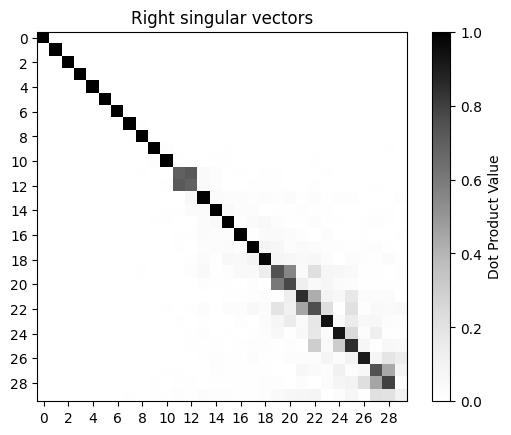

In [15]:
plt.imshow(dot_product, cmap="Grays", vmin=0, vmax=1)
plt.colorbar(label='Dot Product Value')
plt.title("Right singular vectors")
plt.xticks(range(0, n_components, 2))
plt.yticks(range(0, n_components, 2))
plt.show()

In [16]:
dot_product = np.abs(tsvd.u.data.T @ tsvd_rechunk.u.data)

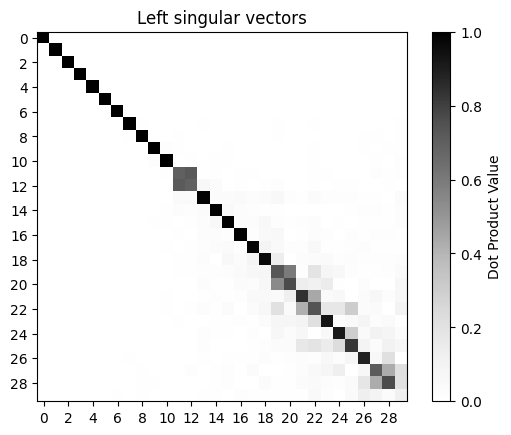

In [17]:
plt.imshow(dot_product, cmap="Grays", vmin=0, vmax=1)
plt.colorbar(label='Dot Product Value')
plt.xticks(range(0, n_components, 2))
plt.yticks(range(0, n_components, 2))
plt.title("Left singular vectors")
plt.show()

Similarly, the singular values are almost identical up to the 10th component, at which point we start to see differences.

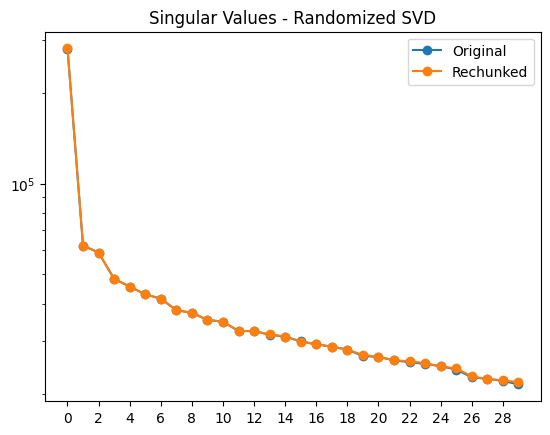

In [18]:
plt.plot(tsvd.s, "-o", label="Original")
plt.plot(tsvd_rechunk.s, "-o", label="Rechunked")
plt.yscale("log")
plt.legend()
plt.title("Singular Values - Randomized SVD")
plt.xticks(range(0, n_components, 2))
plt.show()

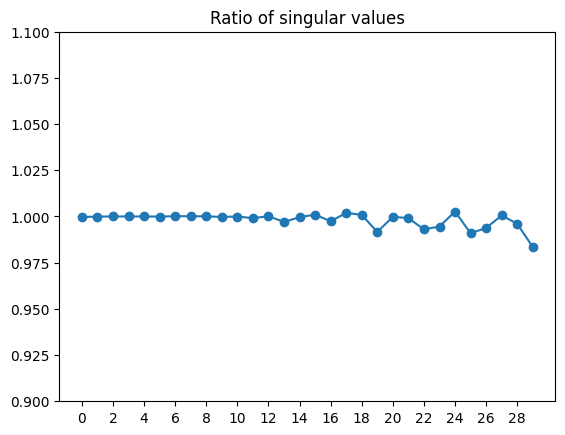

In [19]:
ratio = tsvd.s/tsvd_rechunk.s
plt.plot(ratio, "o-")
plt.title("Ratio of singular values")
plt.ylim([0.9, 1.1])
plt.xticks(range(0, n_components, 2))
plt.show()

Let's now compute the variance explained by each of the SVD components.

In [20]:
tsvd_rechunk.compute_var_ratio()

2025-08-01 14:10 - SVD - INFO - Computing explained variance ratio...
2025-08-01 14:11 - SVD - INFO - Done.


As shown, with only 30 components we can retain more than 80% of the original variance, with the first component alone explaining more than 55%. That's a very high compression ratio, considering the original matrix has 4,380 columns.

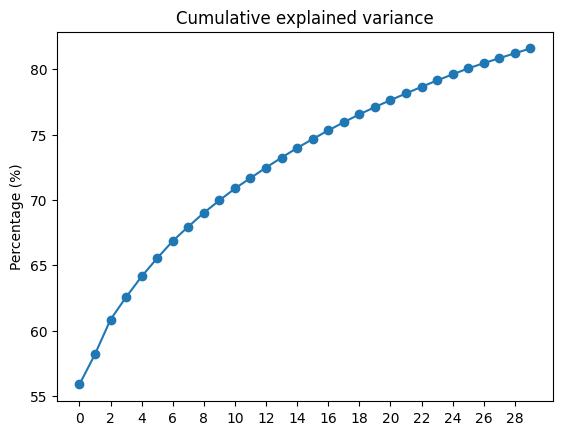

In [21]:
plt.plot(np.cumsum(tsvd_rechunk.explained_var_ratio) * 100, "o-")
plt.title("Cumulative explained variance")
plt.ylabel("Percentage (%)")
plt.xticks(range(0, n_components, 2))
plt.show()

In [25]:
# calculate the compression ratio

compression_ratio = X.nbytes / (
    tsvd_rechunk.u.nbytes + tsvd_rechunk.v.nbytes + 4*len(tsvd_rechunk.s)
)
print(f"Compression ratio: {compression_ratio:.2f}")

Compression ratio: 145.39


We can also plot the right and left singular vectors to see if they represent anything we can physically interpret.

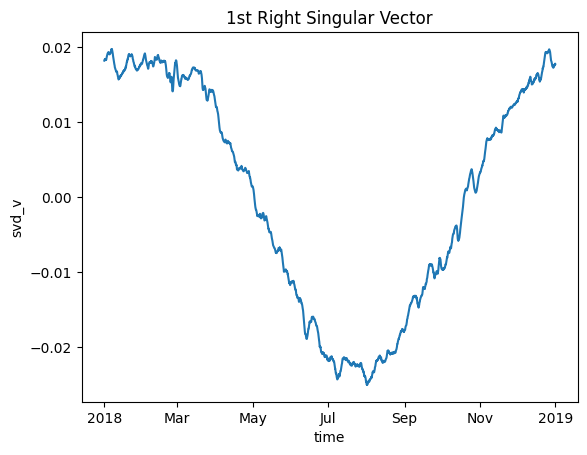

In [ ]:
# plot the first right singular vector, which contains temporal information
tsvd_rechunk.v[0, :].plot()
plt.title("1st Right Singular Vector")
plt.show()

Now plot the first left singular vector, which contains the associated spatial information. We will first need to unstack it to recover the original lat/lon coordinates.

In [27]:
u = tsvd_rechunk.u.copy().unstack()

In [28]:
u

<xarray.DataArray 'svd_u' (components: 30, latitude: 721, longitude: 1440)> Size: 125MB
array([[[-1.5907420e-03, -1.5907420e-03, -1.5907420e-03, ...,
         -1.5907420e-03, -1.5907420e-03, -1.5907420e-03],
        [-1.5878715e-03, -1.5878817e-03, -1.5878947e-03, ...,
         -1.5878381e-03, -1.5878507e-03, -1.5878616e-03],
        [-1.5845906e-03, -1.5846168e-03, -1.5846392e-03, ...,
         -1.5845196e-03, -1.5845427e-03, -1.5845690e-03],
        ...,
        [ 8.1086974e-04,  8.1092358e-04,  8.1098068e-04, ...,
          8.1069954e-04,  8.1075652e-04,  8.1081223e-04],
        [ 8.1161445e-04,  8.1164099e-04,  8.1166968e-04, ...,
          8.1152428e-04,  8.1155344e-04,  8.1158493e-04],
        [ 8.1287290e-04,  8.1287290e-04,  8.1287290e-04, ...,
          8.1287290e-04,  8.1287290e-04,  8.1287290e-04]],

       [[-2.2382259e-03, -2.2382259e-03, -2.2382259e-03, ...,
         -2.2382259e-03, -2.2382259e-03, -2.2382259e-03],
        [-2.2571257e-03, -2.2576184e-03, -2.2566882e-03, ...,
         -2.2569022e-03, -2.2563341e-03, -2.2567715e-03],
        [-2.2728865e-03, -2.2738751e-03, -2.2743768e-03, ...,
         -2.2740604e-03, -2.2733747e-03, -2.2735868e-03],
...
         -6.5396988e-04, -5.6906079e-04, -6.7354168e-04],
        [-6.2486343e-04, -6.4037286e-04, -5.5778673e-04, ...,
         -4.3581682e-04, -4.6345641e-04, -6.1398844e-04],
        [-7.4740883e-04, -7.4740883e-04, -7.4740883e-04, ...,
         -7.4740883e-04, -7.4740883e-04, -7.4740883e-04]],

       [[ 1.0781812e-03,  1.0781812e-03,  1.0781811e-03, ...,
          1.0781812e-03,  1.0781812e-03,  1.0781812e-03],
        [ 7.8342319e-04,  1.0047348e-03,  8.2777167e-04, ...,
          1.1472525e-03,  8.0038473e-04,  9.0362504e-04],
        [ 9.7450084e-04,  7.5200718e-04,  9.3869527e-04, ...,
          6.9478614e-04,  1.0157991e-03,  8.4116694e-04],
        ...,
        [ 2.1939736e-04,  2.4828568e-04,  1.5084239e-04, ...,
          2.4958883e-04,  3.0003791e-04,  2.3922352e-04],
        [ 2.1762130e-04,  2.2565521e-04,  1.7666123e-04, ...,
          2.5582738e-04,  3.5014984e-04,  3.2346965e-05],
        [ 1.9283610e-04,  1.9283610e-04,  1.9283610e-04, ...,
          1.9283610e-04,  1.9283610e-04,  1.9283610e-04]]],
      shape=(30, 721, 1440), dtype=float32)
Coordinates:
  * latitude    (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level       int64 8B 500
  * components  (components) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29

To plot the the left singular vectors, we will make use of the [Cartopy library](https://scitools.org.uk/cartopy/docs/latest/), which makes plotting geospatial data very easy.

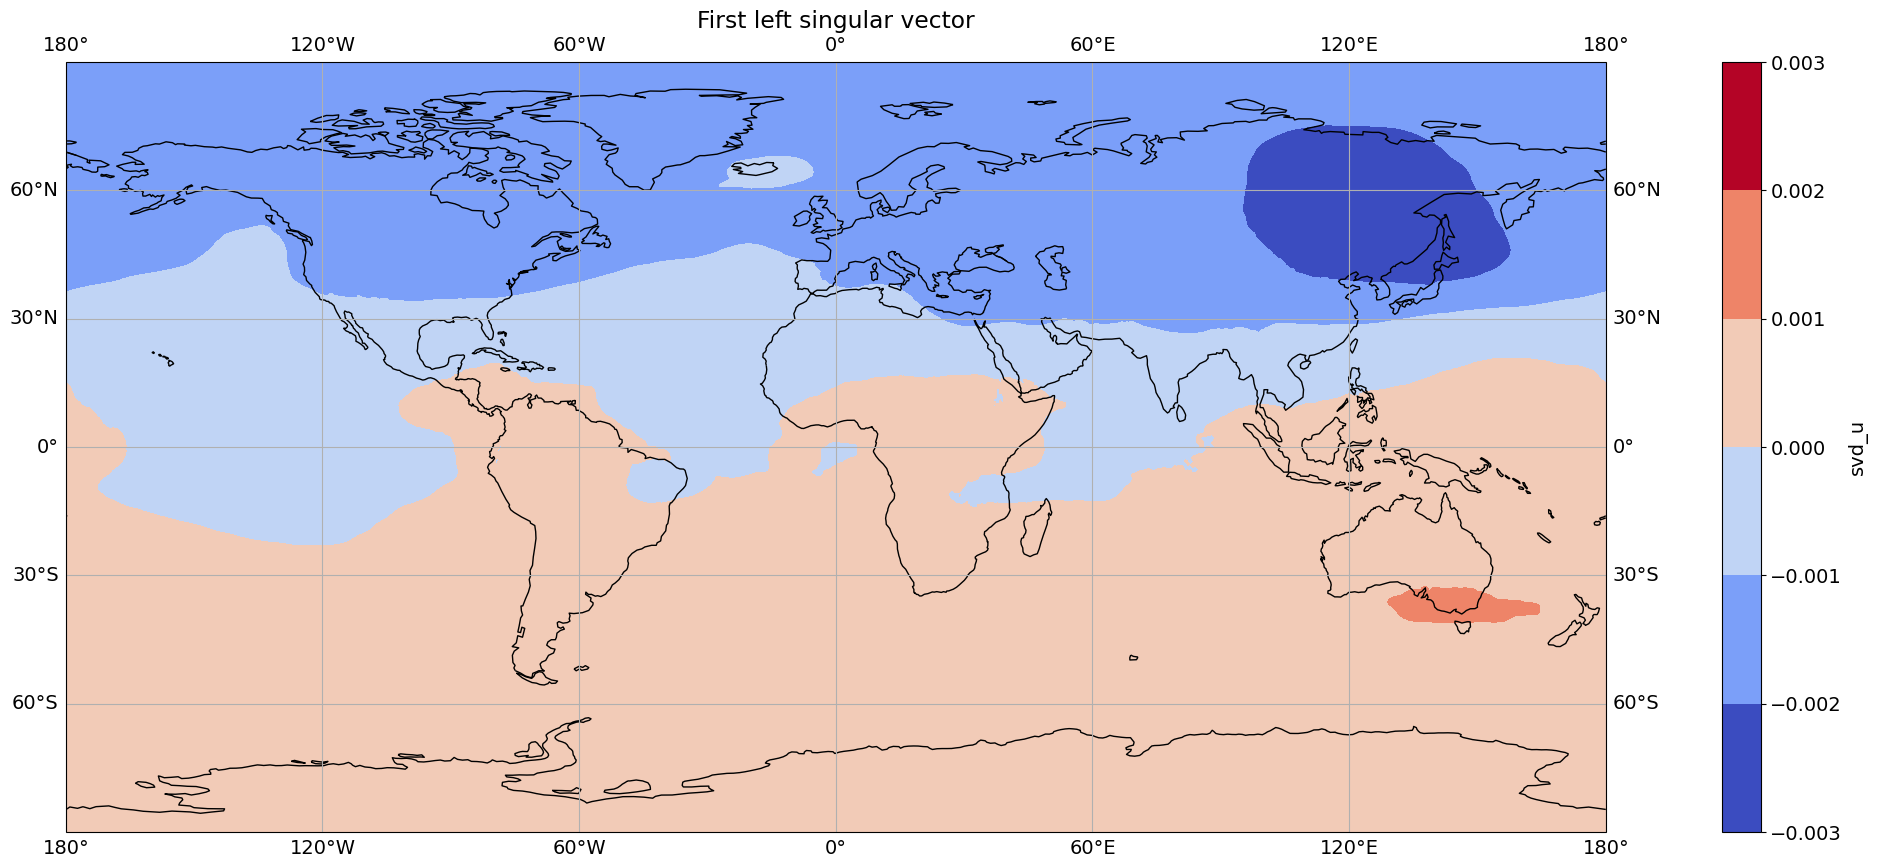

In [31]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

u[0, :, :].plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)

plt.title("First left singular vector")
plt.show()

Clearly, the first SVD mode represents the the summer/winter fluctuation in temperature. The right singular vector `v` shows strong annual periodicity, and the left singular vector `u` shows regions of the world where the temperature fluctuations associated with this annual period are linearly correlated (i.e. the clear split between the Northern and Southern hemispheres).

SVDROM also allows to easily reconstruct snapshots using the results of the SVD calculation. By reconstruction, we mean projection of the data onto the original space of the input array `X`. This can give us a visual indication of how well the compression has retained the original information.

In [40]:
snapshot_0 = tsvd_rechunk.reconstruct_snapshot(0)

We also need to ensure we unstack the data to recover the lat/lon coordinates and to add the time-average back.

In [41]:
snapshot_0 = snapshot_0.unstack() + scaler.mean

In [42]:
X = X.unstack() + scaler.mean

In [43]:
snapshot_0

<xarray.DataArray (latitude: 721, longitude: 1440)> Size: 4MB
array([[230.69836, 230.69836, 230.69836, ..., 230.69836, 230.69836,
        230.69836],
       [230.78224, 230.64404, 230.72658, ..., 230.67577, 230.68741,
        230.71552],
       [230.70116, 230.89165, 230.68997, ..., 230.69986, 230.78055,
        230.74907],
       ...,
       [243.86906, 243.90158, 244.00175, ..., 243.91698, 243.96115,
        243.94345],
       [243.86214, 243.82925, 243.87572, ..., 243.71866, 243.79626,
        243.83087],
       [243.7677 , 243.7677 , 243.7677 , ..., 243.7677 , 243.7677 ,
        243.7677 ]], shape=(721, 1440), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500
    time       datetime64[ns] 8B 2018-01-01

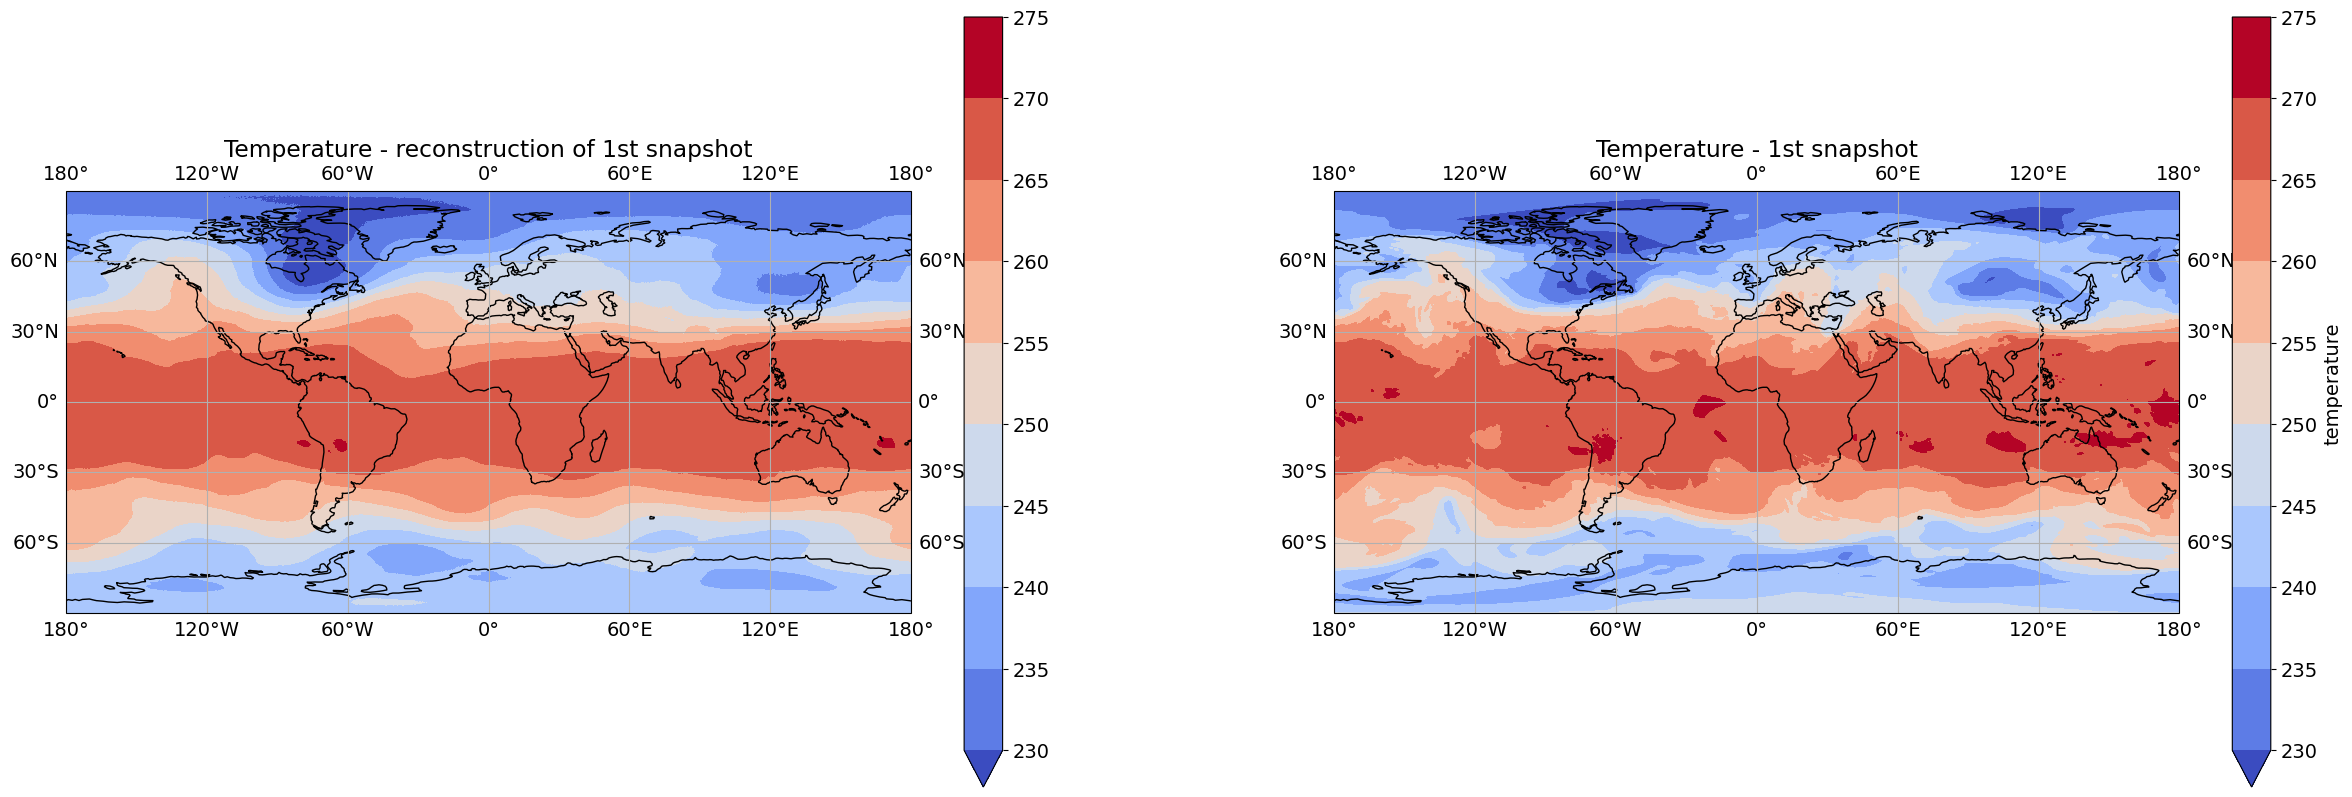

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax = axs[0]
snapshot_0.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(230, 280, 5)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("Temperature - reconstruction of 1st snapshot")

ax = axs[1]
X.isel(time=0).plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(230, 280, 5)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("Temperature - 1st snapshot")

plt.show()

Clearly the reconstruction is considerably smoothed out compared to the original snapshot, but that's because we are just retaining a bit over 80% of the original variance in this case. If we kept more SVD components, we would obtain a more accurate reconstruction.

It is good practice to close the connection to the dataset on disk and to shut down the Dask cluster.

In [51]:
X.close()
client.close()

## Conclusion

This notebook has illustrated that, for a tall-and-skinny matrix, it is preferable to have all columns contained in the same chunk if they can fit in memory. This improves both accuracy and speed of computation. This can be achieved by setting the parameter `rechunk=True` in the `TruncatedSVD.fit()` method. We have also shown that we can do a SVD of a 17 GiB ERA5 slice locally in under a minute, retaining over 80% of the original variance, with a compression ratio of 145. Because SVDROM maintains the original metadata throughout the computations by making a clever use of Xarray labelled data, it is very easy to plot the SVD results across the temporal or spatial dimensions.